# Posterior Distribution

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan
from scipy import stats

In [18]:
# general data processing
original_data = pd.read_csv('groceries.csv').iloc[:, 4:]
data = original_data.iloc[1:]
data.iloc[:, 2:] = data.iloc[:, 2:].astype(float)
data = data.reset_index(drop=True)
data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Unnamed: 4,Unnamed: 5,Apples,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Bananas,Unnamed: 13,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Chicken breasts,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,ALDI,Lichtenberg,0.88,2.2,1,1.88,0.6,1.89,1,1.69,...,6,1.59,10,1.59,0.6,3.99,1,5.99,NaN,NaN
1,ALDI,Neukölln,1,2.99,1,1.79,0.8,1.89,1,1.15,...,10,1.19,6,1.59,0.6,3.99,1,5.99,0.35,3.99
2,ALDI,Neukölln,2,2.49,1,1.79,1,1.15,1,1.15,...,10,1.19,6,1.59,0.6,3.99,1,5.99,NaN,NaN
3,ALDI,Kreuzberg,1,2.99,1,1.79,1,2.29,1,1.15,...,10,1.19,6,1.59,0.6,3.99,0.4,2.99,0.4,2.79
4,ALDI,Kreuzberg,0.6,1.95,2,2.29,1,1.39,1,1.69,...,10,1.19,6,1.59,0.35,2.99,0.6,3.99,1,5.99


In [19]:
# get store and location info
name = data.iloc[:, :2]
name.columns = ['store', 'address']

# get product info and process column names
products = []
for i in list(original_data.columns):
    if 'Unnamed' not in i:
        products.append(i)
brand = range(3)
df = pd.DataFrame(np.arange(2520).reshape((84,30)), 
            index = range(84),
            columns=['' for i in range(30)])
df.columns = pd.MultiIndex.from_product([products, brand])

# merging info about store and location with price
new = name.join(df)

# dropping Seoul and San Francisco stores
indexNames = new[new.store == 'Lotte Mart'].index
indexNames2 = new[new.store == 'Safeway'].index
new.drop(indexNames, inplace=True)
new.drop(indexNames2, inplace=True)
data.drop(indexNames, inplace=True)
data.drop(indexNames2, inplace=True)

# normalizing the price
for i in range(len(new)):
    for j in range(2, 32):
        if pd.isnull(data.iloc[i, 2*j-1]) == False:
            new.iloc[i, j] = data.iloc[i, 2*j-1] / data.iloc[i, 2*j-2]
        else:
            new.iloc[i, j] = np.nan
# enumerate the categories for stores and locations
new.store, mapping_index_1 = pd.Series(new.store).factorize()
new.address, mapping_index_2 = pd.Series(new.address).factorize()
print(data.shape)
print(new.shape)

# separate the data into 3 sets, one for the price, one for store multipliers, one for location multipliers
data_ = [[new.iloc[j, i] for j in range(len(new))] for i in range(2, 32)]
store_ = [[new.iloc[j, 0] for j in range(len(new))] for i in range(2, 32)]
loc_ = [[new.iloc[j, 1] for j in range(len(new))] for i in range(2, 32)]
# convert to numpy array
data_= np.array(data_)
store_= np.array(store_)
loc_= np.array(loc_)

# fill in empty cells (with no data) with 0
for i in range(len(data_)):
    for j in range(len(data_[i])):
        if pd.isna(data_[i, j]):
            data_[i, j] = 0


print(len(data_), len(data_[0]))
print(len(store_), len(store_[0]))
print(len(loc_), len(loc_[0]))

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(79, 62)
(79, 32)
30 79
30 79
30 79


In [20]:
print(data_)

[[ 2.5         2.99        1.245      ...  5.5         2.9
   2.55      ]
 [ 1.88        1.79        1.79       ...  3.3         2.55
   2.9       ]
 [ 3.15        2.3625      1.15       ...  6.4         2.32
   2.32      ]
 ...
 [ 6.65        6.65        6.65       ...  6.23       14.75
   9.15555556]
 [ 5.99        5.99        5.99       ...  9.24        7.15
  11.33333333]
 [ 0.         11.4         0.         ...  6.03        9.81
  16.        ]]


In [21]:
# stan data
stan_data = {
    # info about data
    'data_set': data_,
    'store_set': store_,
    'loc_set': loc_,
    'num_col': 30,
    'num_row': 79,
    'num_pro': 10,
    'num_store': 7,
    'num_loc': 21,
    # prior parameters
    'pro_1': 0,
    'pro_2': 1000,
    'loc_1': 1,
    'loc_2': 0.1,
    'store_1': 1,
    'store_2': 0.1,
    'sig1': 0.3,
    'sig2': 0.2,}

In [22]:
stan_code = '''

data {
    int<lower=0> num_col; // info about data
    int<lower=0> num_row;
    int<lower=0> num_pro;
    int<lower=0> num_store;
    int<lower=0> num_loc;
    real<lower=0> pro_1; // prior parameters
    real<lower=0> pro_2;
    real<lower=0> loc_1;
    real<lower=0> loc_2;
    real<lower=0> store_1;
    real<lower=0> store_2;
    real<lower=0> sig1;
    real<lower=0> sig2;
    real<lower=0> data_set[num_col, num_row]; // data
    int<lower=0> store_set[num_col, num_row];
    int<lower=0> loc_set[num_col, num_row];
}

parameters {
    vector<lower=0>[num_pro] product; // declare prior for base price
    vector<lower=0>[num_pro] sigma2; // declare prior for variance of final price
    vector<lower=0>[num_store] store; // declare prior for store multipliers
    vector<lower=0>[num_loc] location; // declare prior for location multipliers
}

model {
    product ~ uniform(pro_1, pro_2); // prior for base price
    sigma2 ~ normal(sig1, sig2); // prior for variance of final price
    store ~ cauchy(store_1, store_2); // prior for store multipliers
    location ~ cauchy(loc_1, loc_2); // prior for location multipliers
    for (i in 1:num_pro) {
        for (j in 1:num_row) {
            // match the data point with corresponding product, location and store
            if (data_set[i*3-2, j] != 0)
            data_set[i*3-2, j] ~ normal(product[i]*store[store_set[i*3-2, j]+1]*location[loc_set[i*3-2, j]+1], sigma2[i])  
            ;
            if (data_set[i*3-1, j] != 0) 
            data_set[i*3-1, j] ~ normal(product[i]*store[store_set[i*3-1, j]+1]*location[loc_set[i*3-1, j]+1], sigma2[i])
            ;
            if (data_set[i*3-2, j] != 0) 
            data_set[i*3, j] ~ normal(product[i]*store[store_set[i*3, j]+1]*location[loc_set[i*3, j]+1], sigma2[i])
            ;
        }
    }
}
'''



In [23]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad4696b60a4e98fe27cb2e628b0207af NOW.


In [24]:
results = stan_model.sampling(data=stan_data)

In [25]:
print(results)

Inference for Stan model: anon_model_ad4696b60a4e98fe27cb2e628b0207af.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
product[1]     3.04    0.01   0.29   2.49   2.86   3.04   3.23   3.64    433   1.01
product[2]     1.98  9.5e-3    0.3   1.42   1.77   1.97   2.17   2.57   1001    1.0
product[3]     4.76    0.02   0.46   3.84   4.46   4.75   5.05    5.7    419   1.01
product[4]     1.41  6.5e-3   0.13   1.15   1.33   1.41    1.5   1.68    422   1.01
product[5]     1.25  5.9e-3   0.16   0.95   1.14   1.25   1.35   1.58    732   1.01
product[6]     3.57    0.02   0.34   2.91   3.34   3.56   3.79   4.24    391   1.01
product[7]     1.22  5.7e-3   0.12   0.98   1.14   1.21   1.29   1.47    470   1.01
product[8]     8.31    0.04   0.73   6.84   7.85   8.31   8.78   9.76    377   1.01
product[9]     0.31  1.5e-3   0.03   0.25   0.29   0.31

# Rental price analysis

## Berlin

In [26]:
samples = results.extract()
# get samples for all locations in Berlin
berlin = [[samples['location'][:, i]] for i in range(9)]

In [27]:
print(berlin)

[[array([1.17907802, 1.00886535, 1.11599215, ..., 1.07807007, 1.17471493,
       1.04610471])], [array([1.0608867 , 0.92748806, 1.14819093, ..., 1.05001524, 1.08435358,
       1.03503861])], [array([0.95964271, 0.8941118 , 1.03413918, ..., 0.99329069, 0.90566123,
       0.89748899])], [array([0.99496463, 0.98468468, 0.97014549, ..., 1.02079064, 0.95938967,
       0.97551283])], [array([0.92965242, 0.78676198, 0.90414611, ..., 1.0175686 , 1.00114868,
       0.89882128])], [array([0.97008007, 0.93635649, 0.99122849, ..., 1.0535404 , 1.03698757,
       1.00558791])], [array([0.84633678, 1.0220493 , 0.9514756 , ..., 1.06564747, 0.93409943,
       0.74257181])], [array([1.05628382, 0.87286716, 0.9854531 , ..., 1.10444044, 1.0031104 ,
       0.89101179])], [array([1.09513583, 1.05585779, 1.1299781 , ..., 1.2344405 , 1.13107602,
       1.03469883])]]


In [28]:
print(mapping_index_1)
print(mapping_index_2)

Index(['ALDI', 'EDEKA', 'Lidl', 'REWE', 'Sainsbury's', 'Tesco Express',
       'Waitrose & Partners'],
      dtype='object')
Index(['Lichtenberg', 'Neukölln', 'Kreuzberg', 'Alt-Treptow', 'Friedrichshain',
       'Mitte', 'Tempelhof', 'Schöneberg', 'Prenzlauer Berg', 'Islington',
       'Fitzrovia', 'Elephants and Castle', 'Mayfair', 'Hoxton', 'Barbican',
       'Farringdon', 'Clapton', 'Shoreditch', 'Marylebone', 'Saint Pancras',
       'Crouch End'],
      dtype='object')


In [29]:
# average monthly rental price per square meter in ber
rental_berlin = {'Lichtenberg': 9.64, 'Neukölln': 10.09, 'Kreuzberg': 12.99, 'Alt-Treptow': 9.61, 'Friedrichshain': 12.99,
       'Mitte': 12.5, 'Tempelhof': 10.26, 'Schöneberg': 10.26, 'Prenzlauer Berg': 14.5}

multi_berlin = {}
for i in range(9):
    multi_berlin[mapping_index_2[i]] = berlin[i]

In [30]:
print(multi_berlin)

{'Lichtenberg': [array([1.17907802, 1.00886535, 1.11599215, ..., 1.07807007, 1.17471493,
       1.04610471])], 'Neukölln': [array([1.0608867 , 0.92748806, 1.14819093, ..., 1.05001524, 1.08435358,
       1.03503861])], 'Kreuzberg': [array([0.95964271, 0.8941118 , 1.03413918, ..., 0.99329069, 0.90566123,
       0.89748899])], 'Alt-Treptow': [array([0.99496463, 0.98468468, 0.97014549, ..., 1.02079064, 0.95938967,
       0.97551283])], 'Friedrichshain': [array([0.92965242, 0.78676198, 0.90414611, ..., 1.0175686 , 1.00114868,
       0.89882128])], 'Mitte': [array([0.97008007, 0.93635649, 0.99122849, ..., 1.0535404 , 1.03698757,
       1.00558791])], 'Tempelhof': [array([0.84633678, 1.0220493 , 0.9514756 , ..., 1.06564747, 0.93409943,
       0.74257181])], 'Schöneberg': [array([1.05628382, 0.87286716, 0.9854531 , ..., 1.10444044, 1.0031104 ,
       0.89101179])], 'Prenzlauer Berg': [array([1.09513583, 1.05585779, 1.1299781 , ..., 1.2344405 , 1.13107602,
       1.03469883])]}


In [31]:
berlin_sorted = sorted(rental_berlin, key=rental_berlin.get)

In [32]:
rental_berlin_2 = {}
for i in range(0, 9):
    rental_berlin_2[berlin_sorted[i]] = i+1

rental_berlin_3 = {}
for i in range(0, 9):
    rental_berlin_3[berlin_sorted[i]] = rental_berlin[berlin_sorted[i]]

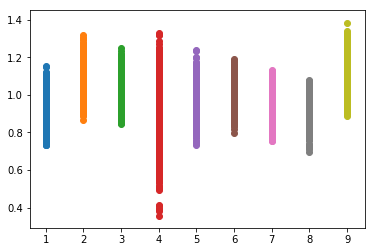

In [33]:
for each in berlin_sorted:
    plt.scatter([rental_berlin_2[each] for i in range(4000)], multi_berlin[each])

In [35]:
# linear regression
slope, intercept, r_val, p_val, se = stats.linregress([np.mean(multi_berlin[each]) for each in berlin_sorted],[rental_berlin_3[each] for each in berlin_sorted])

In [38]:
print('r_value and p_value for berlin rental price and multiplier: ', r_val, p_val)

r_value and p_value for berlin rental price and multiplier:  0.1384763891691476 0.7223673247106321


## London

In [39]:
ls_london = ['Islington',
       'Fitzrovia', 'Elephants and Castle', 'Mayfair', 'Hoxton', 'Barbican',
       'Farringdon', 'Clapton', 'Shoreditch', 'Marylebone', 'Saint Pancras',
       'Crouch End']
#average rental price per week
london_rental = {'Islington': 704,
       'Fitzrovia': 877, 'Elephants and Castle': 813, 'Mayfair': 1843, 'Hoxton': 870, 'Barbican': 1200,
       'Farringdon': 515, 'Clapton': 420, 'Shoreditch': 810, 'Marylebone': 1133, 'Saint Pancras': 900,
       'Crouch End': 435}


In [40]:
london = [[samples['location'][:, i]] for i in range(9, 21)]
# linear regression
slope, intercept, r_val, p_val, se = stats.linregress([np.mean(each) for each in london],[london_rental[each] for each in ls_london])

In [41]:
print('r_value and p_value for london rental price and multiplier: ', r_val, p_val)

r_value and p_value for london rental price and multiplier:  -0.05586112313573571 0.8630996268499319
